In [1]:
import numpy as np

from helper_functions_tsp import read_file_name, validate_distance_array
from helper_functions_tsp import find_problem_size, cost_fn_fact
from helper_functions_tsp import read_index, hot_start
from helper_functions_tsp import convert_bit_string_to_cycle

from graph_functions import parameter_graph, cost_graph

from quantum_functions import define_parameters, create_initial_rotations
from quantum_functions import bind_weights, vqc_circuit, my_gradient, cost_func_evaluate

In [2]:
CONTROL_FILE = 'control/control_parameters.csv'
ENCODING = 'utf-8-sig'      #Encoding of csv file
GRAPH_DIRECTORY = 'graphs/'
LOCATIONS = 4                 #number of locations to be visited

SHOTS = 1024                  #shots used for each call of the quantum circuit
EPSILON = np.pi/2             #constant for parameter shift
MODE = 2                      # MODE = 1 rxgate, rygate, cnot gates
                              # MODE = 2 rxgate, XX gates
#RELEVANT_VALUES = 50         #controls how many of the items to average over as a percentage
                              #eg 100 = all 
                              #30 = top 30%
ETA = 0.005                   #eta - learning rate for parameter shift
UPDATES = 10                  #updates, or iterations
PRINT_FREQUENCY = 2           #how often results are printed out
GRAY = False                   #Use Gray codes
HOT_START = True              #Make a hot start
VERBOSE = False               #controls how much is printedx
#SPSA = False                 #SPSA stochastic gradient descent used

## Read in the control file
The executions are controlled by a CSV parameter file in the control directory

In [3]:
control_dict = read_index(CONTROL_FILE, ENCODING)
print(control_dict)

{0: {'id': '0', 'locations': '5', 'mode': '1', 'eta': '0.005', 'updates': '50', 'print_frequency': '5', 'gray': '1', 'verbose': '1', 'optimiser': 'tbc'}, 1: {'id': '1', 'locations': '5', 'mode': '2', 'eta': '0.005', 'updates': '50', 'print_frequency': '5', 'gray': '1', 'verbose': '1', 'optimiser': 'tbc'}}


From the number of locations visited find the qubits and longest binary string.

In [4]:
bin_len, qubits = find_problem_size(LOCATIONS)
print(f'There are {qubits} qubits needed.  The longest binary string is {bin_len}')

There are 3 qubits needed.  The longest binary string is 2


Data sources are held locally to avoid downstream dependencies.

In [5]:
data_sources = {  4 : {'file' : 'data/four_d.txt', 'best' : 21},
                  5 : {'file' : 'data/five_d.txt', 'best' : 19},
                 11 : {'file' : 'data/dg11_d.txt', 'best' : 253},
                 15 : {'file' : 'data/p01_d.txt',  'best' : 291},
                 17 : {'file' : 'data/gr17_d.txt', 'best' : 2085},
                 26 : {'file' : 'data/fri26_d.txt', 'best' : 699},
                 42 : {'file' : 'data/dantzig42_d.txt', 'best' : 33_523},
                }

Read the data, and print out the filename and best distance held in the data.

In [6]:
filename = read_file_name(LOCATIONS, data_sources)
best_dist = data_sources[LOCATIONS]['best']
print(f'Data will be read from filename {filename}.  It is known that the shortest distance is {best_dist}.')

Data will be read from filename data/four_d.txt.  It is known that the shortest distance is 21.


Read and validate the distance array.  This checks the array is the correct shape, and is symmetric.

In [7]:
distance_array = np.genfromtxt(filename)
validate_distance_array(distance_array, LOCATIONS)

Define the VQC circuits with appropriate parameters, and draw the circuit.

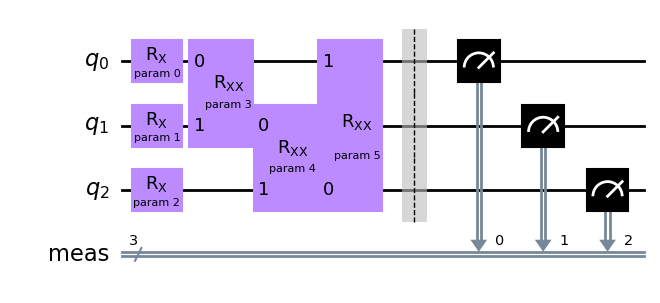

In [8]:
params = define_parameters(qubits, MODE)
qc = vqc_circuit(qubits, params, MODE)
qc.draw("mpl", style="clifford")

Iterate over the control parameters and do one experiment for each one of them.

Create random initial rotations, and bind these to the parameters in a new circuit `bc`.

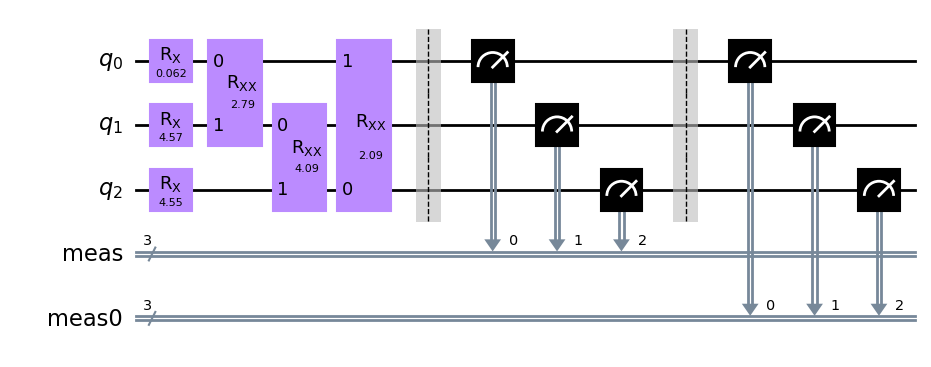

In [9]:
if HOT_START:
    hot_start_list = hot_start(distance_array, LOCATIONS)
    

init_rots = create_initial_rotations(qubits, HOT_START)
bc = bind_weights(params, init_rots, qc)
bc.measure_all()
bc.draw("mpl", style="clifford")

In [10]:
cost_fn = cost_fn_fact(LOCATIONS, distance_array, gray=GRAY, verbose=False)
cost_start, lowest_to_date, _ = cost_func_evaluate(cost_fn, bc, SHOTS)
print(f'For the starting circuit the average cost is {cost_start} and the lowest cost is {lowest_to_date}')

For the starting circuit the average cost is 22.109375 and the lowest cost is 21.0


In [11]:
rots = init_rots
cost_list, lowest_list, index_list, gradient_list = [], [], [], []
for i in range(UPDATES):
    bc = bind_weights(params, rots, qc)
    cost, lowest, lowest_energy_bit_string = cost_func_evaluate(cost_fn, bc, SHOTS)
    if i == 0:
        lowest_string_to_date = lowest_energy_bit_string
        lowest_to_date = lowest
    if lowest < lowest_to_date:
        lowest = lowest_to_date
        lowest_string_to_date = lowest_energy_bit_string
    route_list = convert_bit_string_to_cycle(lowest_string_to_date, LOCATIONS, gray=GRAY)
    index_list.append(i)
    cost_list.append(cost)
    lowest_list.append(lowest)
    gradient = np.array(my_gradient(cost_fn, qc, params, rots, EPSILON, SHOTS))
    gradient_list.append(gradient)
    if i % PRINT_FREQUENCY == 0:
        print(f'For iteration {i} the average cost from the sample is {cost} and the lowest cost from the sample is {lowest}')
        print(f'The lowest cost to date is {lowest_to_date} corresponding to bit string {lowest_string_to_date} ')
        print(f'and route {route_list}')
        if VERBOSE:
            print(f'The gradient is {gradient}')
    rots = rots - ETA * gradient

For iteration 0 the average cost from the sample is 22.140625 and the lowest cost from the sample is 21.0
The lowest cost to date is 21.0 corresponding to bit string [1, 1, 1] 
and route [0, 1, 3, 2]
For iteration 2 the average cost from the sample is 22.12109375 and the lowest cost from the sample is 21.0
The lowest cost to date is 21.0 corresponding to bit string [1, 1, 1] 
and route [0, 1, 3, 2]
For iteration 4 the average cost from the sample is 22.12109375 and the lowest cost from the sample is 21.0
The lowest cost to date is 21.0 corresponding to bit string [1, 1, 1] 
and route [0, 1, 3, 2]
For iteration 6 the average cost from the sample is 22.14453125 and the lowest cost from the sample is 21.0
The lowest cost to date is 21.0 corresponding to bit string [1, 1, 1] 
and route [0, 1, 3, 2]
For iteration 8 the average cost from the sample is 22.06640625 and the lowest cost from the sample is 21.0
The lowest cost to date is 21.0 corresponding to bit string [1, 1, 1] 
and route [0, 1

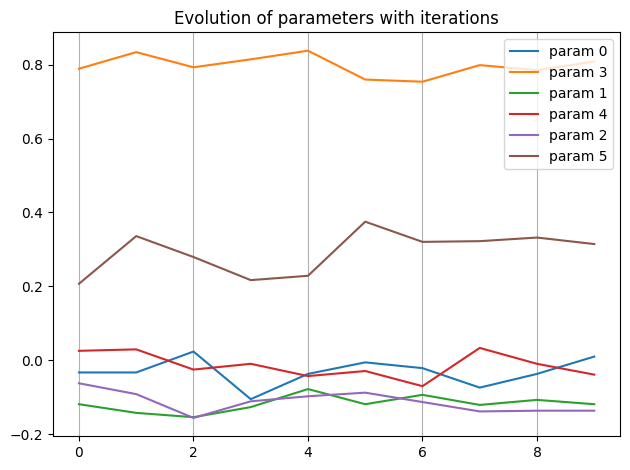

In [12]:
legend = [params[i].name for i, param in enumerate(params)] 
filename = GRAPH_DIRECTORY+f'Test'
parameter_graph(filename, index_list, gradient_list, legend)


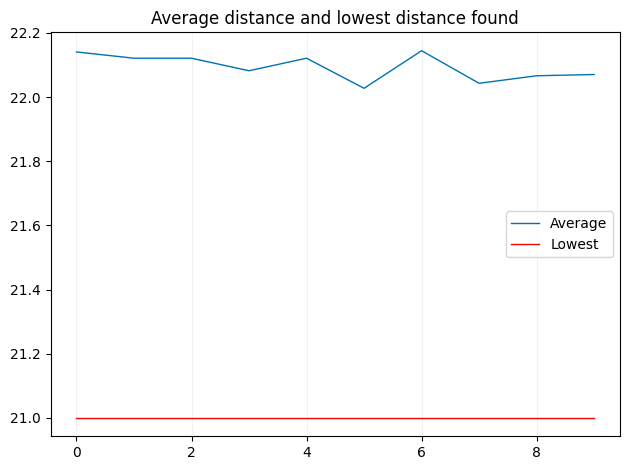

In [13]:
filename = GRAPH_DIRECTORY+f'Test2'
cost_graph(filename, index_list, cost_list, lowest_list)

In [14]:
#from helper_functions_tsp import convert_bit_string_to_cycle
#locs = 4
#bit_string = [1, 0, 1] 
#expected_result = [0, 1, 3, 2]
#result = convert_bit_string_to_cycle(bit_string, locs, gray = True)
#print(result)

In [17]:
#from helper_functions_tsp import hot_start_list_to_string
##hot_start_list = [0, 3, 1, 4, 2]
#hot_start_list = [0, 3, 2, 1]
#GRAY = False
#string = hot_start_list_to_string(hot_start_list, LOCATIONS, GRAY)
##bit_string = [1, 0, 1, 1, 1] 
#bit_string = [1, 0, 1] 
#print(string)

[1, 2, 3]
[3, 2, 1]
bin_len - 2
index = 2 integer = 3, hot_start_list = [3, 2, 1], initial_list, [1, 2, 3]
0b10
10
10
bin_len - 1
index = 1 integer = 2, hot_start_list = [3, 2, 1], initial_list, [1, 2]
0b1
1
1
[1, 0, 1]


In [16]:
LOCATIONS

4